In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggrastr)
library(ggrepel)
library(tibble)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## Prepare the avgs for comparisons & visualizations
avgFile <- "./load_files/RGC_ExN_avgs_regions.rds"

if (!file.exists(avgFile)){
    ## ExN AVGs
    seu <- readRDS(file = paste0("./overview/load_files/ExN.harmony.spread_region.v1.harmony.rds"))

    e911_up <- colnames(seu)[seu@meta.data$subtype %in% "ExN up ACTN2" & 
                             seu@meta.data$cbnage %in% c("E93", "E110") & 
                             seu@meta.data$lobe != "Insula"]
    e67_deep <- colnames(seu)[seu@meta.data$subtype %in% c("ExN deep NR4A2 GRID2", "ExN deep SYT6") & 
                              seu@meta.data$cbnage %in% c("E62-64", "E77-78")]
    exn <- seu[, c(e67_deep, e911_up)]
    exn@meta.data$avgcls <- paste0(exn$subtype, "_", exn$lobe)
    Idents(exn) <- "avgcls"
    avg_exn <- log(AverageExpression(exn, assay = "RNA")$RNA + 1)


    ## late RGCs (oRG)
    load(file = paste0("../../MF4_RGC/overview/load_files/", "Pseudobulk_by_region_oRG_v1.Rdata"))
    ## avgs, pmeta, rgc_cbn, 
    org <- rgc_cbn
    Idents(org) <- "lobe"
    avg_org <- log(AverageExpression(org, assay = "RNA")$RNA + 1)
    colnames(avg_org) <- paste0("oRG_", colnames(avg_org))


    ## early RGCs (NESC & vRG-early & vRG-late)
    load(file = paste0("../../MF4_RGC/overview/load_files/", "Pseudobulk_by_region_tRG_v3.Rdata"))
    ## avgs, pmeta, rgc_cbn,  
    rgearly <- rgc_cbn %>%
                subset(cluster %in% c("NEP RSPO3 DIRAS3", "NEP RSPO3 TEX15", "vRG HMGA2 CCND1"))
    Idents(rgearly) <- "lobe"
    avg_rgearly <- log(AverageExpression(rgearly, assay = "RNA")$RNA + 1)
    colnames(avg_rgearly) <- paste0("RGearly_", colnames(avg_rgearly))
    
    rglate <- rgc_cbn %>%
                subset(cluster %in% c("vRG SAT1 STMN2"))
    Idents(rglate) <- "lobe"
    avg_rglate <- log(AverageExpression(rglate, assay = "RNA")$RNA + 1)
    colnames(avg_rglate) <- paste0("RGlate_", colnames(avg_rglate))


    avgs <- list(avg_exn, 
                 avg_org[rownames(avg_exn), ], 
                 avg_rglate[rownames(avg_exn), ], 
                 avg_rgearly[rownames(avg_exn), ]) %>%
            do.call(cbind, .)

    colnames(avgs) <- gsub("ExN deep NR4A2 GRID2", "L6B", colnames(avgs)) %>%
            gsub("ExN deep SYT6", "L6 CT", .) %>%
            gsub("ExN up ACTN2", "upIT", .) %>%
            gsub("OcC", "OC", .)


    saveRDS(avgs, file = avgFile)
}


In [3]:
avgs <- readRDS(avgFile)
avgs <- avgs[setdiff(rownames(avgs), "RPS4Y1"), ] ## RPS4Y1 is a sex-related gene
head(avgs)
colnames(avgs)


,L6B_FC,L6 CT_FC,L6 CT_OC,L6B_OC,L6 CT_TC,L6B_TC,L6 CT_MSC,L6B_MSC,upIT_FC,upIT_MSC,⋯,oRG_FC,oRG_OC,oRG_TC,RGlate_FC,RGlate_OC,RGlate_MSC,RGlate_TC,RGearly_FC,RGearly_OC,RGearly_MSC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PGBD2,0.034185434,0.007395413,0.008867529,0.01644795,0.002981825,0.01799257,0.009659029,0.02136724,0.087780923,0.08813542,⋯,0.02491554,0.03782348,0.028315283,0.01550360,0.009558522,0.032270121,0.012407288,0.020648000,0.018961371,0.010147649
LOC114674980,0.000000000,0.000000000,0.000000000,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,⋯,0.00000000,0.00000000,0.004035349,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
TRNAE-CUC,0.000000000,0.000000000,0.000000000,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,⋯,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
ZNF692,0.112958766,0.115979594,0.075528293,0.11194295,0.062839174,0.09300746,0.051651414,0.10457213,0.116099749,0.13096867,⋯,0.08079629,0.10965238,0.129499020,0.11733801,0.098837513,0.096994413,0.058920656,0.066738438,0.061873157,0.039327406
TRNAL-CAA,0.000000000,0.000000000,0.000000000,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,⋯,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
LOC114678402,0.005475559,0.000000000,0.002323255,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,0.001477288,0.00106058,⋯,0.00421719,0.01788917,0.003121062,0.01430305,0.006212349,0.003239593,0.006845363,0.006959737,0.005577355,0.003642577


[1] "L6B_FC"      "L6 CT_FC"    "L6 CT_OC"    "L6B_OC"      "L6 CT_TC"   
 [6] "L6B_TC"      "L6 CT_MSC"   "L6B_MSC"     "upIT_FC"     "upIT_MSC"   
[11] "upIT_TC"     "upIT_OC"     "oRG_MSC"     "oRG_FC"      "oRG_OC"     
[16] "oRG_TC"      "RGlate_FC"   "RGlate_OC"   "RGlate_MSC"  "RGlate_TC"  
[21] "RGearly_FC"  "RGearly_OC"  "RGearly_MSC"

In [4]:
## Calculate fold changes between regions
## avgs: average expression
## cols: comparion columns
## pd_expr: pseudovalue for the expression
CalcFC <- function(avgs, cols, pd_expr) {
    fc <- lapply(cols, function(x) {
        fc_mat <- lapply(setdiff(cols, x), function(y) (avgs[, x] + pd_expr)/(avgs[, y] + pd_expr)) %>%
            setNames(., paste0(x, "|", setdiff(cols, x))) %>%
            as.data.frame(., check.names = FALSE)
        meanFC <- apply(fc_mat, 1, mean) ## use the mean FC(reg/background)
        names(meanFC) <- rownames(avgs)
        meanFC
    }) %>%
    setNames(., cols) %>%
    as.data.frame(., check.names= FALSE)
    return(fc)
}


CalcFC_All <- function(avg, all_regions, reference_cluster){
    up_fc <- CalcFC(avgs = avg, cols = paste0("upIT", "_", all_regions), pd_expr = 0.1)
    l6b_fc <- CalcFC(avgs = avg, cols = paste0("L6B", "_", all_regions), pd_expr = 0.1)
    ct_fc <- CalcFC(avgs = avg, cols = paste0("L6 CT", "_", all_regions), pd_expr = 0.1)
    ref_cols <- paste0(reference_cluster, "_", all_regions) %>% 
                                intersect(., colnames(avg))
    ref_fc <- CalcFC(avgs = avg, cols = ref_cols, pd_expr = 0.05)
    all_fc <- list(ref_fc, up_fc, l6b_fc, ct_fc) %>%
                        do.call(cbind, .) %>%
                        as.matrix()
    all_fc <- log2(all_fc)
    all_fc[all_fc > 3] <- 3 ## ceiling at 3
    all_fc[all_fc < 0] <- 0 ## ceiling at 3
    return(all_fc)
}                 


## Prepare the plot data
## fc_matrix: fold change matrix of allsubtypes/regions
## reference_cluster: reference rgc subtype
## region: brain region to analyze
## label_threshold: threshold to use to label region-specific genes
PreparePlotData <- function(fc_matrix, region, reference_cluster, label_threshold = c(0.9, 0.9)) {
    reg_cols <- c("#FF420E", "#FFBB00", "#4CB5F5", "#89DA59", "#878787", "#B037C4") %>% 
                            setNames(., c("FC", "MSC", "TC", "OC", "Insula", "GE"))
    cur_cols <- c(reg_cols[region], "lightgrey") %>% 
                            setNames(., c("yes", "no"))

    set.seed(42)
    pdata <- fc_matrix[, paste0(c(reference_cluster, c("upIT", "L6B", "L6 CT")), "_", region)] %>%
                        as.data.frame() %>%
                        tibble::rownames_to_column("gene") %>%
                        tidyr::gather(., "type", "x_value", paste0(c("upIT", "L6B", "L6 CT"), "_", region))
    colnames(pdata) <- gsub(paste0(reference_cluster, "_", region), "y_value", colnames(pdata))
    pdata <- pdata %>%
                        mutate(ishl = ifelse(x_value >= label_threshold[1] & y_value >= label_threshold[2], 
                                             "yes", "no")) %>%
                        mutate(label = ifelse(ishl %in% "yes", gene, NA)) %>%
                        mutate(ref_region = region, 
                               ref_cluster = reference_cluster) %>%
                        mutate(color = cur_cols[ishl]) %>%
                        mutate(type = sapply(strsplit(type, "_", fixed = TRUE), "[", 1))
    return(pdata)
}

In [5]:
## RGearly: DEGs shared between RGearly & ExNs

## calculate fold changes
ref_cls <- "RGearly"
all_regs <- switch(ref_cls,
                RGearly = c("FC", "MSC", "OC"),
                RGlate = c("FC", "MSC", "TC", "OC"))
all_fc <- CalcFC_All(avg = avgs, all_regions = all_regs, reference_cluster = ref_cls)                 
head(all_fc)
sum(is.na(all_fc))

,RGearly_FC,RGearly_MSC,RGearly_OC,upIT_FC,upIT_MSC,upIT_OC,L6B_FC,L6B_MSC,L6B_OC,L6 CT_FC,L6 CT_MSC,L6 CT_OC
PGBD2,0.13686980,0,0.085874034,0.00000000,0.000000,0.127876868,0.17500464,0,0.00000000,0.0000000,0.02030498,0.00467369
LOC114674980,0.00000000,0,0.000000000,0.00000000,0.000000,0.000000000,0.00000000,0,0.00000000,0.0000000,0.00000000,0.00000000
TRNAE-CUC,0.00000000,0,0.000000000,0.00000000,0.000000,0.000000000,0.00000000,0,0.00000000,0.0000000,0.00000000,0.00000000
ZNF692,0.23287533,0,0.144514867,0.02846233,0.169289,0.000000000,0.03265726,0,0.02237524,0.4085157,0.00000000,0.00000000
TRNAL-CAA,0.00000000,0,0.000000000,0.00000000,0.000000,0.006705873,0.00000000,0,0.00000000,0.0000000,0.00000000,0.00000000
LOC114678402,0.06123103,0,0.008485801,0.00000000,0.000000,0.010943518,0.07690874,0,0.00000000,0.0000000,0.00000000,0.03313406


[1] 0

In [6]:
## Transform data for visualization
pdata2 <- lapply(all_regs, function(ref_reg) {
            pdata <- PreparePlotData(fc_matrix = all_fc, region = ref_reg, 
                                     reference_cluster = ref_cls, label_threshold = c(0.9, 0.9))
            return(pdata)
            }) %>%
            do.call(rbind, .)
pdata2$ref_region <- factor(pdata2$ref_region, levels = all_regs)
saveRDS(pdata2, file = paste0("./load_files/", "RGC_ExN_shareDEGs_", ref_cls, "_genes.rds"))

Warning message:
“Removed 311527 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 311527 rows containing missing values (geom_text_repel).”


png 
  2

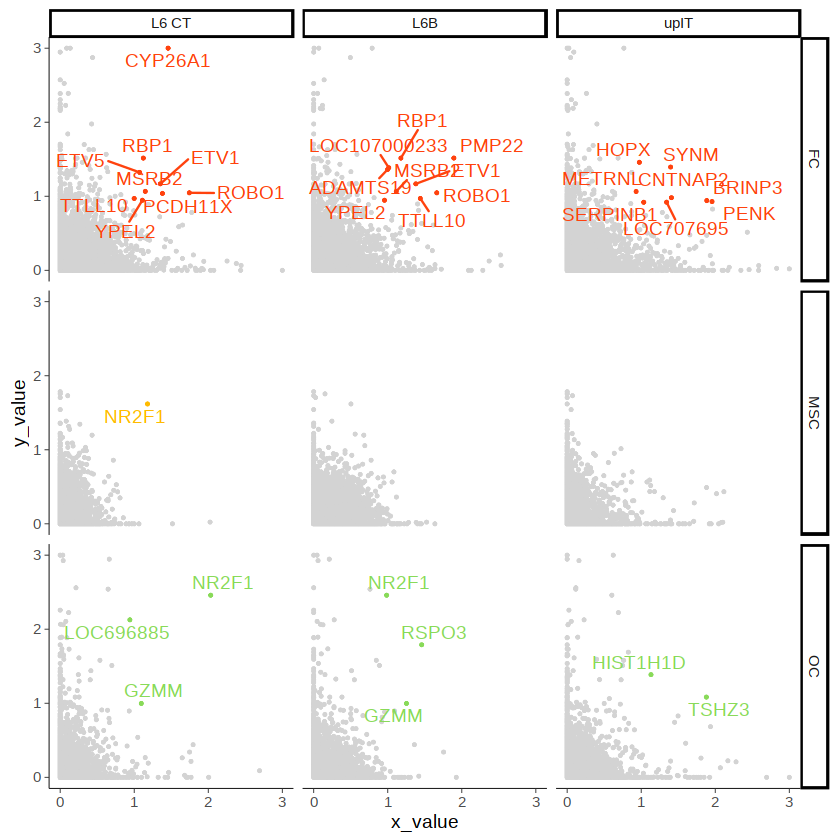

In [7]:
## Visualization
set.seed(42)
p1 <- ggplot(pdata2, aes_string(x = "x_value", y = "y_value", color = "color")) +
            rasterise(geom_point(size = 1, shape = 16), dpi = 300, scale = 1) +
            ggrepel::geom_text_repel(aes_string(label = "label")) +
            theme_classic() +
            scale_color_identity() +
            facet_grid(ref_region ~ type)+
            coord_fixed(xlim = c(0,3), ylim = c(0, 3)) +
            theme(axis.line = element_line(size = 0.2), 
                axis.ticks = element_line(size = 0.2))
p1

pdf(paste0("./report/", "RGC_ExN_", ref_cls, "_all.pdf"), width = 2.5*3, height = 2.5 * length(all_regs))
print(p1)
dev.off()


In [8]:
## RGlate: DEGs shared between RGlate & ExNs

## calculate fold changes
ref_cls <- "RGlate"
all_regs <- switch(ref_cls,
                RGearly = c("FC", "MSC", "OC"),
                RGlate = c("FC", "MSC", "TC", "OC"))
all_fc <- CalcFC_All(avg = avgs, all_regions = all_regs, reference_cluster = ref_cls)                 
head(all_fc)
sum(is.na(all_fc))

,RGlate_FC,RGlate_MSC,RGlate_TC,RGlate_OC,upIT_FC,upIT_MSC,upIT_TC,upIT_OC,L6B_FC,L6B_MSC,L6B_TC,L6B_OC,L6 CT_FC,L6 CT_MSC,L6 CT_TC,L6 CT_OC
PGBD2,0.0000000,0.3989243,0,0.0000000,0.00000000,0.0000000,0.28881530,0.025984285,0.17852233,0,0,0.00000000,0.004174657,0.04413126,0,0.03028544
LOC114674980,0.0000000,0.0000000,0,0.0000000,0.00000000,0.0000000,0.00000000,0.000000000,0.00000000,0,0,0.00000000,0.000000000,0.00000000,0,0.00000000
TRNAE-CUC,0.0000000,0.0000000,0,0.0000000,0.00000000,0.0000000,0.00000000,0.000000000,0.00000000,0,0,0.00000000,0.000000000,0.00000000,0,0.00000000
ZNF692,0.3406673,0.1001254,0,0.1236474,0.02352899,0.1496694,0.00542575,0.000000000,0.07000434,0,0,0.06090884,0.408159644,0.00000000,0,0.02293723
TRNAL-CAA,0.0000000,0.0000000,0,0.0000000,0.00000000,0.0000000,0.00000000,0.006705873,0.00000000,0,0,0.00000000,0.000000000,0.00000000,0,0.00000000
LOC114678402,0.2153383,0.0000000,0,0.0000000,0.00000000,0.0000000,0.00000000,0.010101959,0.07690874,0,0,0.00000000,0.000000000,0.00000000,0,0.03313406


[1] 0

In [9]:
## Transform data for visualization
pdata2 <- lapply(all_regs, function(ref_reg) {
            pdata <- PreparePlotData(fc_matrix = all_fc, region = ref_reg, 
                                     reference_cluster = ref_cls, label_threshold = c(0.9, 0.9))
            return(pdata)
            }) %>%
            do.call(rbind, .)
pdata2$ref_region <- factor(pdata2$ref_region, levels = all_regs)
saveRDS(pdata2, file = paste0("./load_files/", "RGC_ExN_shareDEGs_", ref_cls, "_genes.rds"))

Warning message:
“Removed 415370 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 415370 rows containing missing values (geom_text_repel).”


png 
  2

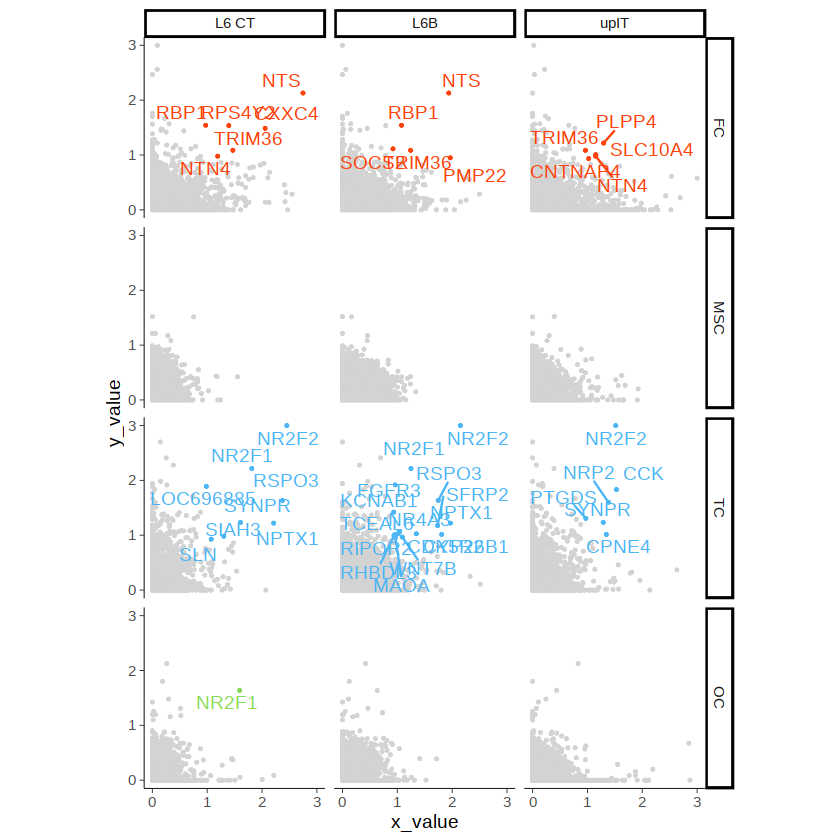

In [10]:
## Visualization
set.seed(42)
p1 <- ggplot(pdata2, aes_string(x = "x_value", y = "y_value", color = "color")) +
            rasterise(geom_point(size = 1, shape = 16), dpi = 300, scale = 1) +
            ggrepel::geom_text_repel(aes_string(label = "label")) +
            theme_classic() +
            scale_color_identity() +
            facet_grid(ref_region ~ type)+
            coord_fixed(xlim = c(0,3), ylim = c(0, 3)) +
            theme(axis.line = element_line(size = 0.2), 
                axis.ticks = element_line(size = 0.2))
p1

pdf(paste0("./report/", "RGC_ExN_", ref_cls, "_all.pdf"), width = 2.5*3, height = 2.5 * length(all_regs))
print(p1)
dev.off()


`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.

Warning message:
“Removed 138413 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 138413 rows containing missing values (geom_text_repel).”


png 
  2

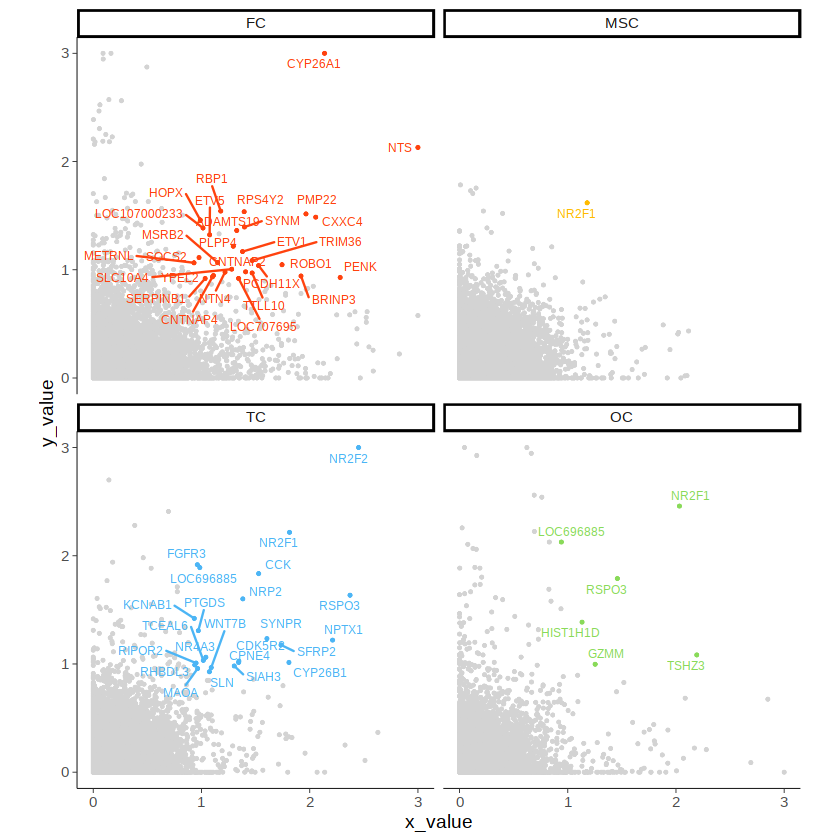

In [11]:
## Combine the RGearly & RGlate results for summary visualization (main figure)
early_data <-  readRDS(file = paste0("./load_files/", "RGC_ExN_shareDEGs_", "RGearly", "_genes.rds")) %>%
                    mutate(ref_region = as.character(ref_region))
late_data <-  readRDS(file = paste0("./load_files/", "RGC_ExN_shareDEGs_", "RGlate", "_genes.rds")) %>%
                    mutate(ref_region = as.character(ref_region))


reg_cols <- c("#FF420E", "#FFBB00", "#4CB5F5", "#89DA59", "#878787", "#B037C4") %>% 
                setNames(., c("FC", "MSC", "TC", "OC", "Insula", "GE"))
summary_data <- rbind(early_data, late_data) %>%
            mutate(x_value = MinMax(x_value, min = 0, max = 3)) %>%
            group_by(gene, ref_region) %>%
            summarize(x_value = max(x_value), y_value = max(y_value), ishl = sum(ishl == "yes")) %>%
            ungroup() %>%
            mutate(label = ifelse(ishl >= 1, gene, NA)) %>%
            mutate(color = ifelse(ishl >= 1, reg_cols[as.character(ref_region)], "lightgrey")) %>%
            mutate(ref_region = factor(ref_region, levels = c("FC", "MSC", "TC", "OC")))

library(ggrastr)
set.seed(42)
psum <- ggplot(summary_data, aes_string(x = "x_value", y = "y_value", color = "color")) +
            rasterise(geom_point(size = 1, shape = 16), dpi = 300, scale = 1) +
            geom_text_repel(aes_string(label = "label"), size = 2.5) +
            theme_classic() +
            scale_color_identity() +
            facet_wrap(vars(ref_region), nrow = 2, ncol = 2)+
            coord_fixed(xlim = c(0,3), ylim = c(0, 3)) +
            theme(axis.line = element_line(size = 0.2), 
                axis.ticks = element_line(size = 0.2))
psum

pdf(paste0("./report/", "RGC_ExN_earlylate_all.pdf"), width = 2.5*2, height = 2.5 * 2)
print(psum)
dev.off()


In [12]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tibble_3.0.1  ggrepel_0.8.2 ggrastr_1.0.1 ggplot2_3.3.0 dplyr_1.0.7  
[6] Seurat_3.1.5 

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          RcppAnnoy_